In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-08-19 16:36:00.006458: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-08-19 16:36:00.042858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-19 16:36:00.043183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-08-19 16:36:00.043352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-19 16:36:00.044619: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-19 16:36:00.045870: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [4]:
def my_crop(img, start_y, start_x, desired_height, desired_width):
  if K.image_data_format() == 'channels_last':
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    dy = desired_height #input desired output size
    dx = desired_width #input desired output size
    # start_y = (height-dy)//2
    # start_x = (width-dx)//2
    return img[start_y:start_y+dy, start_x:(dx+start_x), :]
  else:
      assert img.shape[0] == 3
      dy = desired_height #input desired output size
      dx = desired_width #input desired output size
      # start_y = (height-dy)//2
      # start_x = (width-dx)//2
      return img[:,start_y:start_y + dy, start_x:(dx + start_x)]

def crop_augmented_generator(batches, start_y, start_x, crop_height, crop_width):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the same images because "batches" was selected to work with class_mode='input'
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
    
      if K.image_data_format() == 'channels_last':
        # print("type of batch_x: ", type(batch_x))
        # print("type of batch_y: ", type(batch_y))
        # print("len of batch_x: ", len(batch_x))

        # Either batch_x or batch_y could be augmented or original
        batch_crops_input_x = np.zeros((batch_x[0].shape[0], crop_height, crop_width, 3))
        batch_crops_target_x = np.zeros((batch_x[1].shape[0], crop_height, crop_width, 3))

        batch_crops_input_y = np.zeros((batch_y[0].shape[0], crop_height, crop_width, 3))
        batch_crops_target_y = np.zeros((batch_y[1].shape[0], crop_height, crop_width, 3))
      else:
        # Either batch_x or batch_y could be augmented or original
        batch_crops_input_x = np.zeros((batch_x[0].shape[0], 3, crop_height, crop_width))
        batch_crops_target_x = np.zeros((batch_x[1].shape[0], 3, crop_height, crop_width))

        batch_crops_input_y = np.zeros((batch_y[0].shape[0], 3, crop_height, crop_width))
        batch_crops_target_y = np.zeros((batch_y[1].shape[0], 3, crop_height, crop_width))

      for i in range(batch_x[0].shape[0]):
        #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
        batch_crops_input_x[i] = my_crop(batch_x[0][i], start_y, start_x, crop_height, crop_width)
        batch_crops_target_x[i] = my_crop(batch_x[1][i], start_y, start_x, crop_height, crop_width)

        batch_crops_input_y[i] = my_crop(batch_y[0][i], start_y, start_x, crop_height, crop_width)
        batch_crops_target_y[i] = my_crop(batch_y[1][i], start_y, start_x, crop_height, crop_width)
      
      # print(type(batch_crops_input_x))
      batch_crops_x = (batch_crops_input_x, batch_crops_target_x)
      batch_crops_y = (batch_crops_input_y, batch_crops_target_y)

      yield (batch_crops_x, batch_crops_y)

  
    
def crop_generator(batches, start_y, start_x, crop_height, crop_width, flag=0):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
      if flag==0:
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
          batch_crops_y = np.zeros((batch_y.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
          batch_crops_y = np.zeros((batch_y.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
            batch_crops_y[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
        yield (batch_crops, batch_crops_y)
      else: 
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)

        yield (batch_crops, batch_y)
         

In [5]:
# batch_size = 64
batch_size = 10
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=97,
                                   brightness_range=[0.88,1.0]) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals and changing the brightness


original_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )

# Generate original images from the original data directory
original_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",
    batch_size=batch_size,
    shuffle = False,
    class_mode='input')

# Combine the generators using the `keras.preprocessing.image.Iterator` class
combined_generator = zip(train_generator, original_generator)

Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.


In [6]:
validation_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 20 images belonging to 1 classes.


In [7]:
anomaly_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 10 images belonging to 1 classes.


In [8]:
test_set_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


Creating the cropped images

In [9]:
HEIGHT = 160
WIDTH = 128

In [10]:
train_crops = crop_augmented_generator(combined_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
val_crops = crop_generator(validation_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
anomaly_crops = crop_generator(anomaly_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
test_crops = crop_generator(test_set_generator, 65, 69, HEIGHT,WIDTH,1)      # top, left, height, width

In [11]:
print(type(train_crops))
print(type(train_generator))

<class 'generator'>
<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>


Here we make sure that both of the returned elements of the cropped generator, that is "imgaes_in_batch" and "imgaes_in_batch2", are indeed cropped images.

In [12]:
images_in_batch, images_in_batch2 = next(train_crops)


In [13]:
print(images_in_batch[0].shape)
print(images_in_batch[1].shape)

print(images_in_batch2[0].shape)
print(images_in_batch2[1].shape)

(10, 160, 128, 3)
(10, 160, 128, 3)
(10, 160, 128, 3)
(10, 160, 128, 3)


In [14]:
print(type(images_in_batch))

<class 'tuple'>


Here, we see the images of the train_generator. The result batches are one to the input batch and the expected output batch. These two are the same since the "class_mode = input" has been selected for this generator. 

In [15]:
images_in_batch, images_in_batch2 = next(train_generator)
print(images_in_batch.shape)
print(images_in_batch2.shape)
print(type(images_in_batch))

(10, 256, 256, 3)
(10, 256, 256, 3)
<class 'numpy.ndarray'>


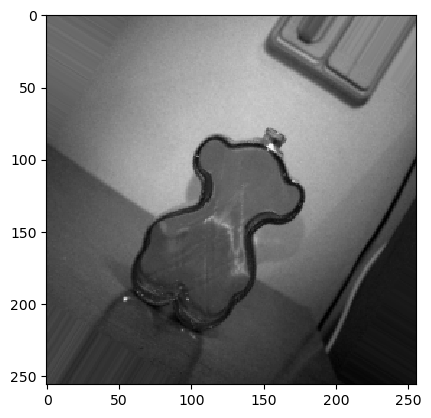

In [16]:
single_img = images_in_batch[0]
plt.imshow(single_img)

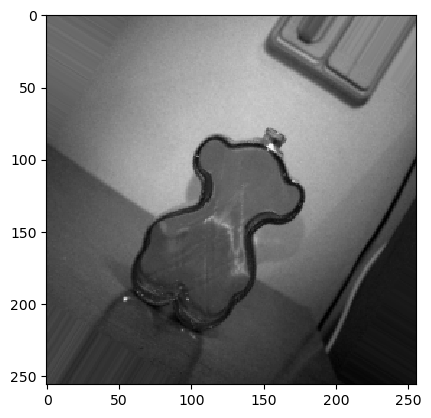

In [17]:
single_img2 = images_in_batch2[0]
plt.imshow(single_img2)

Below, we see that the above images are exactly the same. THis, because of the propert "class_mode=input" of the generator.

In [18]:
single_img == single_img2

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,

Now, looking at the original_generator images.

(10, 256, 256, 3)
(10, 256, 256, 3)
<class 'numpy.ndarray'>


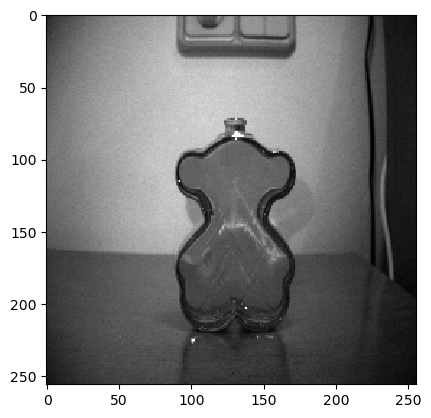

In [19]:
images_in_batch, images_in_batch2 = next(original_generator)
print(images_in_batch.shape)
print(images_in_batch2.shape)
print(type(images_in_batch))
single_img = images_in_batch[0]
plt.imshow(single_img)

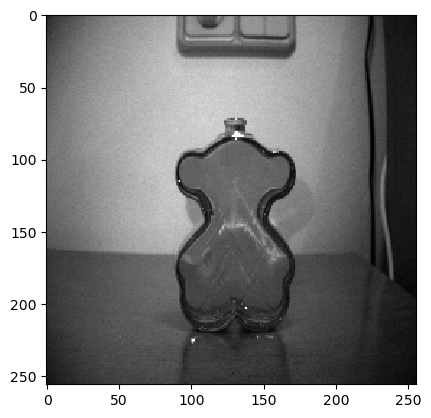

In [20]:
single_img2 = images_in_batch2[0]
plt.imshow(single_img2)

In [21]:
single_img == single_img2

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,

Now, looking at the combined_generator images.

In [22]:
images_in_batch, images_in_batch2 = next(combined_generator)
print(len(images_in_batch))
print(len(images_in_batch2))

2
2


In [23]:
batch_input_images1 = images_in_batch[0]
batch_expected_images1 = images_in_batch[1]
print(batch_input_images1.shape)
print(batch_expected_images1.shape)

(10, 256, 256, 3)
(10, 256, 256, 3)


In [24]:
batch_input_images2 = images_in_batch2[0]
batch_expected_images2 = images_in_batch2[1]
print(batch_input_images2.shape)
print(batch_expected_images2.shape)

(10, 256, 256, 3)
(10, 256, 256, 3)


I assume "images_in_batch" correspond perhaps to the augmented images and "images_in_batch2" correspond to the original images. Let's assess that. We have changed the transformations of the augmented generator to include rotations so we could notices which images correspond to the augmented and which others do not. 

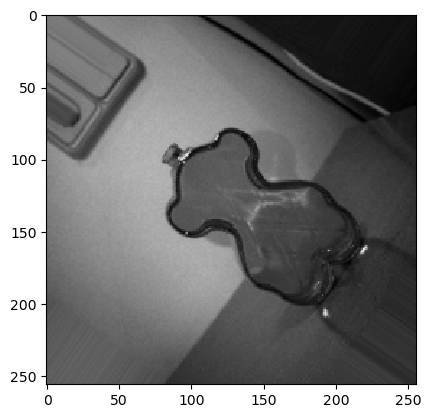

In [25]:
single_img_batch1 = batch_input_images1[0]
plt.imshow(single_img_batch1)

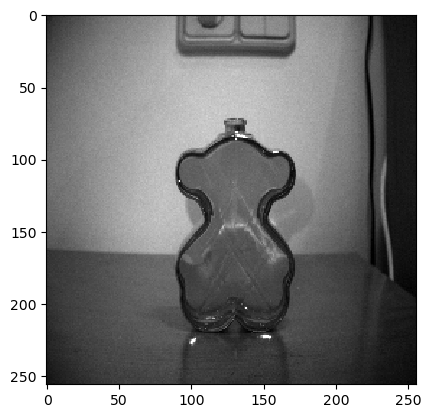

In [26]:
single_img_batch2 = batch_input_images2[0]
plt.imshow(single_img_batch2)

Yes, from above we could asses that the "images_in_batch" list of batches corresponds to the augmented images and "images_in_batch2" list of batches corresponds to the original images.

Of course, if we see the second batches of "images_in_batch" and "images_in_batch2" these correspond to the expected image, hence storing the very same image as their first batch.

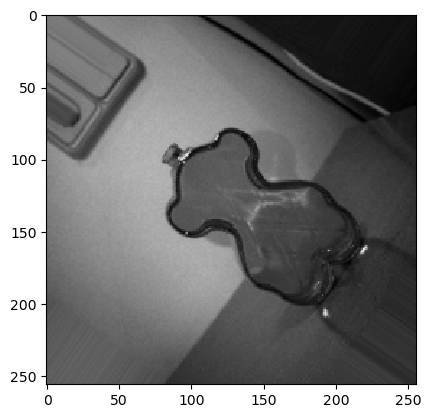

In [27]:
single_expected_img_batch1 = batch_expected_images1[0]
plt.imshow(single_expected_img_batch1)

In [28]:
single_img_batch1 == single_expected_img_batch1

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,

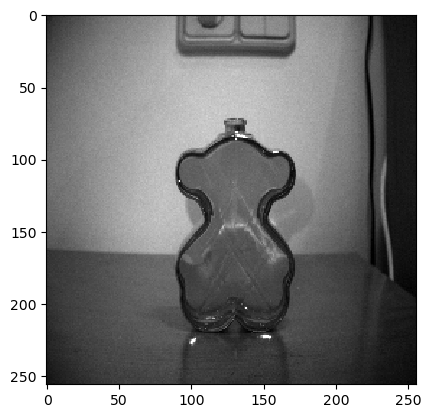

In [29]:
single_expected_img_batch2 = batch_expected_images2[0]
plt.imshow(single_expected_img_batch2)

In [30]:
single_img_batch2 == single_expected_img_batch2

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,

KNowing all these we can check the cropped images:

In [31]:
images_in_batch, images_in_batch2 = next(train_crops)

In [32]:
batch_input_images1 = images_in_batch[0]
batch_expected_images1 = images_in_batch[1]
print(batch_input_images1.shape)
print(batch_expected_images1.shape)

(10, 160, 128, 3)
(10, 160, 128, 3)


In [33]:
batch_input_images2 = images_in_batch2[0]
batch_expected_images2 = images_in_batch2[1]
print(batch_input_images2.shape)
print(batch_expected_images2.shape)

(10, 160, 128, 3)
(10, 160, 128, 3)


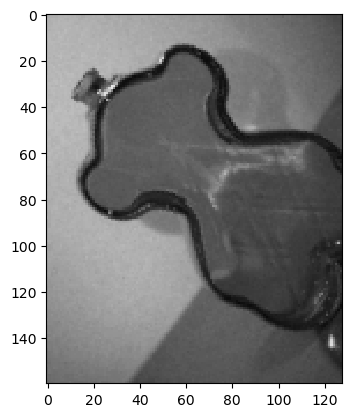

In [34]:
single_img_batch1 = batch_input_images1[0]
plt.imshow(single_img_batch1)

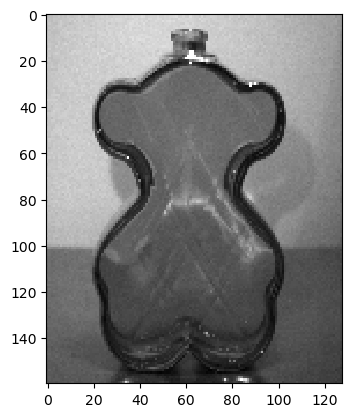

In [42]:
single_img_batch2 = batch_input_images2[0]
plt.imshow(single_img_batch2)

As seen above both images at simple look, seem to be the same. However, the first image seems to have more brightness, perhaps that's what made it to be predicted as anomaly.